In [1]:
#load the Basic libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Load visualization libraries
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.graphics.tsaplots as tsa_plots
from matplotlib.patches import Rectangle
%matplotlib inline

In [3]:
# Load Time series Libraries
import itertools
import statsmodels.formula.api as smf 
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [4]:
raw_data = pd.read_excel('CocaCola_Sales_Rawdata.xlsx')
raw_data.head() 

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [5]:
raw_data.tail() 

,Quarter,Sales
37,Q2_95,4936.0
38,Q3_95,4895.0
39,Q4_95,4333.0
40,Q1_96,4194.0
41,Q2_96,5253.0


In [6]:
data = raw_data.copy()

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


No Null values. Note data type of data columns.

In [8]:
data.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


##### Visualizing the data

In [9]:
viz = pd.read_excel('CocaCola_Sales_Rawdata.xlsx', header = 0, index_col = 0, parse_dates = True, 
                  squeeze = True)
viz[:5]

Quarter
Q1_86    1734.827000
Q2_86    2244.960999
Q3_86    2533.804993
Q4_86    2154.962997
Q1_87    1547.818996
Name: Sales, dtype: float64

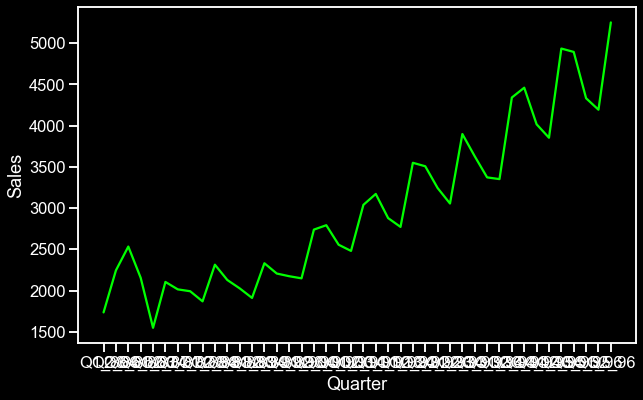

In [10]:
#Line plot
sns.set(rc = {'figure.figsize':(10, 6.18)})
sns.set(style = "ticks", context = "talk")
plt.style.use("dark_background")
sns.lineplot(data = viz, color = 'lime')
plt.show()

There seems to be a upward trend with additive seasonality.

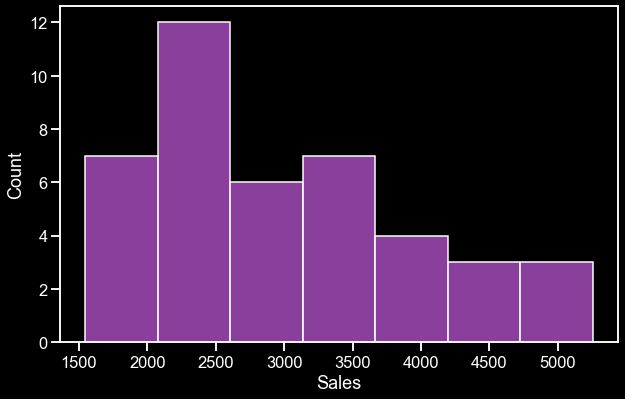

In [11]:
sns.histplot(data = viz, color = 'mediumorchid')
plt.show()

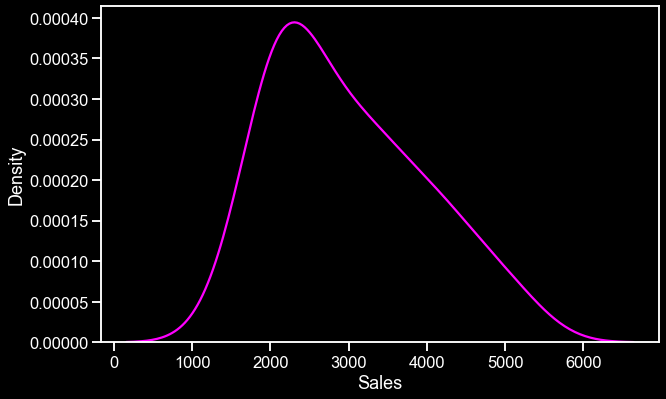

In [12]:
sns.kdeplot(data = viz, color = 'fuchsia')
plt.show() #Density Plot

In [13]:
data['quarters'] = data.Quarter.apply(lambda x : x.split('_')[0])
data['years'] = data.Quarter.apply(lambda x : x.split('_')[1])
data.head()

,Quarter,Sales,quarters,years
0,Q1_86,1734.827000,Q1,86
1,Q2_86,2244.960999,Q2,86
2,Q3_86,2533.804993,Q3,86
3,Q4_86,2154.962997,Q4,86
4,Q1_87,1547.818996,Q1,87


In [14]:
quater_dumies = pd.DataFrame(pd.get_dummies(data.quarters))
data = pd.concat([data, quater_dumies], axis = 1)
data.head()

,Quarter,Sales,quarters,years,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1,86,1,0,0,0
1,Q2_86,2244.960999,Q2,86,0,1,0,0
2,Q3_86,2533.804993,Q3,86,0,0,1,0
3,Q4_86,2154.962997,Q4,86,0,0,0,1
4,Q1_87,1547.818996,Q1,87,1,0,0,0


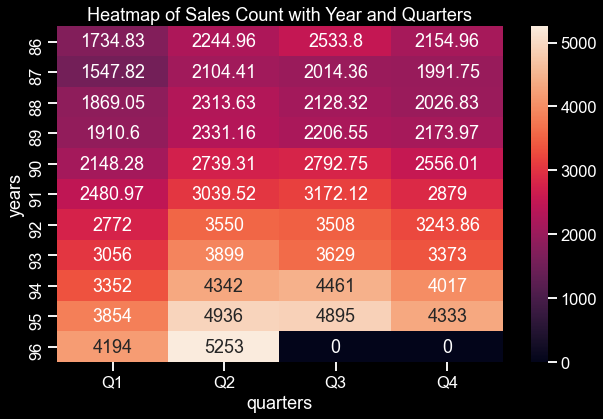

In [15]:
heatmap_y_month = pd.pivot_table(data = data,values = "Sales", index = "years", columns = "quarters", 
                                 aggfunc = "mean", fill_value = 0)
sns.heatmap(heatmap_y_month, annot = True, fmt = "g")
plt.title('Heatmap of Sales Count with Year and Quarters');

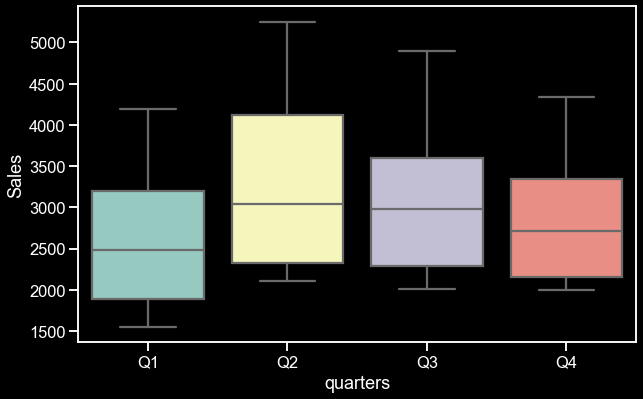

In [16]:
sns.boxplot(x = 'quarters', y = 'Sales', data = data);

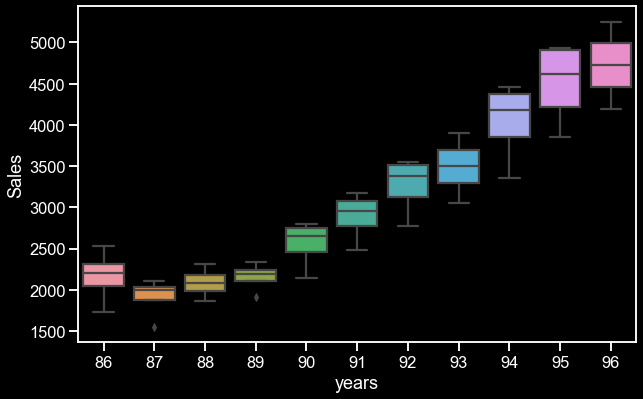

In [17]:
sns.boxplot(x = 'years', y = 'Sales', data = data);

##### Seasonal Decompose plots

In [18]:
decompose_ts = seasonal_decompose(viz, period = 12)

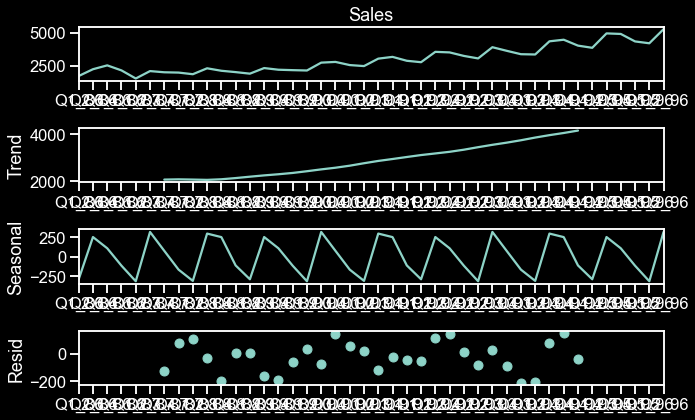

In [19]:
decompose_ts.plot()
plt.show()

There seems to be some patern in the residue.

##### ACF and PACF plots

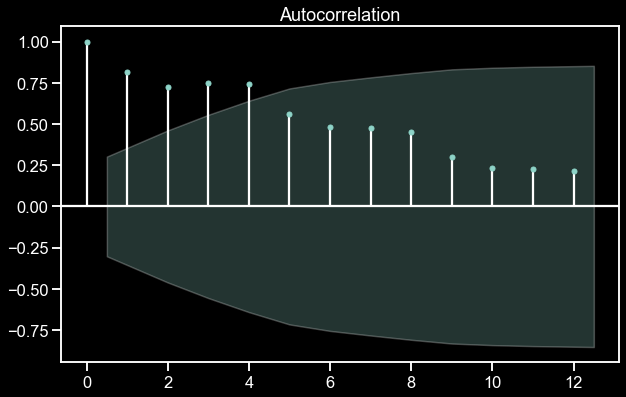

In [20]:
tsa_plots.plot_acf(viz, lags = 12) 
plt.show()

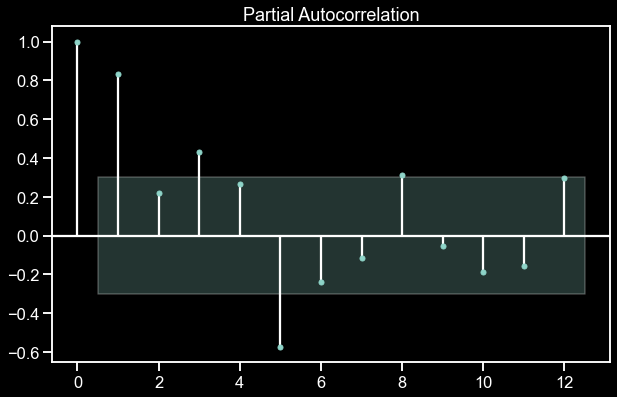

In [21]:
tsa_plots.plot_pacf(viz, lags = 12)
plt.show()

## Preprocess data

#### Transformations

In [22]:
# adding t values >> new variable 1
data['t'] = np.arange(1, data.shape[0] + 1)

In [23]:
# adding t_sqr values >> new variable 2
data['t_sqr'] = data['t']**2

In [24]:
# adding log_ values >> new variable 3
data['log_sales'] = np.log(data['Sales'])

In [25]:
data.head()

,Quarter,Sales,quarters,years,Q1,Q2,Q3,Q4,t,t_sqr,log_sales
0,Q1_86,1734.827000,Q1,86,1,0,0,0,1,1,7.458663
1,Q2_86,2244.960999,Q2,86,0,1,0,0,2,4,7.716443
2,Q3_86,2533.804993,Q3,86,0,0,1,0,3,9,7.837477
3,Q4_86,2154.962997,Q4,86,0,0,0,1,4,16,7.675529
4,Q1_87,1547.818996,Q1,87,1,0,0,0,5,25,7.344602


#### Partition & Metrics

In [26]:
#Partition Series
train = data.iloc[:35]
test = data.iloc[35:]

##### RMSE for Predictive Accuracy
- Model with lowest RMSE is the best

In [27]:
#performance metrics 
pfm_model_bsd = dict() # For model driven
pfm_data_bsd = dict() # For Data driven

## Applying Forecasting Methods
### Model Driven

#### Classical ML Model based Methods

In [28]:
#Linear Model
linear_model = smf.ols('Sales~t', data = train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test['t'])))
rmse_linear = mean_squared_error(test.Sales, pred_linear, squared = False) #RMSE Calculation
pfm_model_bsd.update( {'Linear Model' : rmse_linear} )
rmse_linear

636.5072930351143

In [29]:
#Exponential
Exp = smf.ols('log_sales~t',data = train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(test['t'])))
rmse_Exp = mean_squared_error(test.Sales, pred_Exp, squared = False)
pfm_model_bsd.update( {'Exponential Model' : rmse_Exp} )
rmse_Exp

4515.811064811282

In [30]:
#Quadratic 
Quad = smf.ols('Sales~t+t_sqr', data = train).fit()
pred_Quad = pd.Series(Quad.predict(test[["t", "t_sqr"]]))
rmse_Quad = mean_squared_error(test.Sales, pred_Quad, squared = False)
pfm_model_bsd.update( {'Quadratic Model' : rmse_Quad} )
rmse_Quad

511.811731941731

In [31]:
#Additive seasonality 
add_sea = smf.ols('Sales~Q1+Q2+Q3+Q4', data = train).fit()
pred_add_sea = pd.Series(add_sea.predict(test[['Q1', 'Q2', 'Q3', 'Q4']]))
rmse_add_sea = mean_squared_error(test.Sales, pred_add_sea, squared = False)
pfm_model_bsd.update( {'Additive seasonality' : rmse_add_sea} )
rmse_add_sea

1861.8704164251737

In [32]:
#Additive Seasonality Quadratic 
add_sea_Quad = smf.ols('Sales~t+t_sqr+Q1+Q2+Q3+Q4', data = train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(test[['Q1', 'Q2', 'Q3', 'Q4', 't', 't_sqr']]))
rmse_add_sea_quad = mean_squared_error(test.Sales, pred_add_sea_quad, squared = False)
pfm_model_bsd.update( {'Additive Seasonality Quadratic' : rmse_add_sea_quad} )
rmse_add_sea_quad

309.46413951642813

In [33]:
#Multiplicative Seasonality
Mul_sea = smf.ols('log_sales~Q1+Q2+Q3+Q4', data = train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(test))
rmse_Mult_sea = mean_squared_error(test.Sales, pred_Mult_sea, squared = False)
pfm_model_bsd.update( {'Multiplicative Seasonality' : rmse_Mult_sea} )
rmse_Mult_sea

4516.300741074347

In [34]:
#Multiplicative Additive Seasonality 
Mul_Add_sea = smf.ols('log_sales~t+Q1+Q2+Q3+Q4', data = train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(test))
rmse_Mult_add_sea = mean_squared_error(test.Sales, pred_Mult_add_sea, squared = False)
pfm_model_bsd.update( {'Multiplicative Additive Seasonality ' : rmse_Mult_add_sea} )
rmse_Mult_add_sea 

4515.822756171213

In [35]:
result_model_bsd = pd.DataFrame(pfm_model_bsd.items(), columns = ['MODEL', 'RMSE'])
result_model_bsd.sort_values(by = ['RMSE'])

,MODEL,RMSE
4,Additive Seasonality Quadratic,309.464140
2,Quadratic Model,511.811732
0,Linear Model,636.507293
3,Additive seasonality,1861.870416
1,Exponential Model,4515.811065
6,Multiplicative Additive Seasonality,4515.822756
5,Multiplicative Seasonality,4516.300741


Additive Seasonality Quadratic has the best values.

###### Model Evaluation - Additive Seasonality Quadratic

In [36]:
data2 = data.copy()
data2.head()

,Quarter,Sales,quarters,years,Q1,Q2,Q3,Q4,t,t_sqr,log_sales
0,Q1_86,1734.827000,Q1,86,1,0,0,0,1,1,7.458663
1,Q2_86,2244.960999,Q2,86,0,1,0,0,2,4,7.716443
2,Q3_86,2533.804993,Q3,86,0,0,1,0,3,9,7.837477
3,Q4_86,2154.962997,Q4,86,0,0,0,1,4,16,7.675529
4,Q1_87,1547.818996,Q1,87,1,0,0,0,5,25,7.344602


In [37]:
data2.columns.values

array(['Quarter', 'Sales', 'quarters', 'years', 'Q1', 'Q2', 'Q3', 'Q4',
       't', 't_sqr', 'log_sales'], dtype=object)

In [38]:
data2.drop(['Quarter','Q1', 'Q2', 'Q3', 'Q4','t_sqr', 'log_sales'], axis = 1, inplace = True)
data2 = data2[['t', 'years', 'quarters', 'Sales']] 
data1 = data2.copy()
data3 = data2.copy()
data_fnl = data2.copy()
data2.head()

,t,years,quarters,Sales
0,1,86,Q1,1734.827000
1,2,86,Q2,2244.960999
2,3,86,Q3,2533.804993
3,4,86,Q4,2154.962997
4,5,87,Q1,1547.818996


In [39]:
data2["Predicted"] = pd.Series(add_sea_Quad.predict(data[['Q1', 'Q2', 'Q3', 'Q4', 't', 't_sqr']]))
data2.head()

,t,years,quarters,Sales,Predicted
0,1,86,Q1,1734.827000,1715.011163
1,2,86,Q2,2244.960999,2277.750192
2,3,86,Q3,2533.804993,2194.873446
3,4,86,Q4,2154.962997,1919.651866
4,5,87,Q1,1547.818996,1703.261332


In [40]:
# add a date column in the dataset
data2['Date'] = pd.date_range(start = '1986-01-01', end = '1996-07-01', freq = 'Q')
data2.head()

,t,years,quarters,Sales,Predicted,Date
0,1,86,Q1,1734.827000,1715.011163,1986-03-31
1,2,86,Q2,2244.960999,2277.750192,1986-06-30
2,3,86,Q3,2533.804993,2194.873446,1986-09-30
3,4,86,Q4,2154.962997,1919.651866,1986-12-31
4,5,87,Q1,1547.818996,1703.261332,1987-03-31


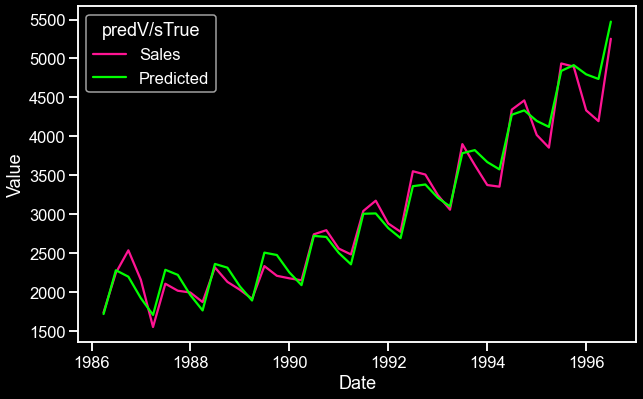

In [41]:
# line plot - View for the entire dataset _ ASQ
viz2 = data2.loc[:, ["Date", "Sales", "Predicted"]].melt("Date", var_name = "predV/sTrue", 
                                                         value_name = "Value")
sns.lineplot(data = viz2, x = viz2.Date, y = viz2.Value, hue = "predV/sTrue", 
             palette = ["deeppink", "lime"]);

There is certain variance in the initial years and final years.

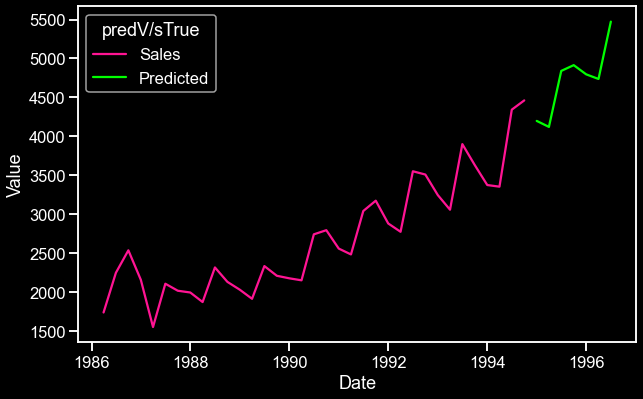

In [42]:
#Line plot - Train V/s Test Plot
data2.Predicted.iloc[:35] = np.nan
data2.Sales.iloc[35:] = np.nan

viz3 = data2.loc[:, ["Date", "Sales", "Predicted"]].melt("Date", var_name = "predV/sTrue", 
                                                         value_name = "Value")
sns.lineplot(data = viz3, x = viz3.Date, y = viz3.Value, hue = "predV/sTrue", 
             palette = ["deeppink", "lime"]);

There is large variance from true value.

### PyCaret

In [43]:
data1.head()

,t,years,quarters,Sales
0,1,86,Q1,1734.827000
1,2,86,Q2,2244.960999
2,3,86,Q3,2533.804993
3,4,86,Q4,2154.962997
4,5,87,Q1,1547.818996


In [44]:
#Partition Series
train1 = data1.iloc[:35]
test1 = data1.iloc[35:]

In [45]:
# import the regression module
from pycaret.regression import *

s = setup(data = train1, test_data = test1, target = 'Sales', 
          fold_strategy = 'timeseries', numeric_features = ['years', 't'], 
          fold = 3, transform_target = True, session_id = 123)

,Description,Value
0,session_id,123
1,Target,Sales
2,Original Data,"(35, 4)"
3,Missing Values,False
4,Numeric Features,2
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(35, 6)"


In [46]:
best = compare_models(sort = 'RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,307.0714,158955.2636,350.2645,-0.2920,0.1309,0.1061,0.0267
gbr,Gradient Boosting Regressor,299.7615,167676.6230,403.7827,-0.1156,0.1305,0.0928,0.0367
dt,Decision Tree Regressor,324.9201,177179.8881,412.0147,-0.1376,0.1332,0.1008,0.0233
br,Bayesian Ridge,358.4199,184113.4097,413.8704,-0.4449,0.1485,0.1197,0.0233
ridge,Ridge Regression,361.2946,185395.6823,415.3163,-0.4618,0.1502,0.1213,0.0200
lr,Linear Regression,373.8745,192453.8359,422.5326,-0.5535,0.1589,0.1284,3.2133
lar,Least Angle Regression,375.8673,193915.7954,425.1590,-0.5597,0.1596,0.1289,0.0200
et,Extra Trees Regressor,351.7371,196713.7477,434.6764,-0.2868,0.1445,0.1098,0.1067
ada,AdaBoost Regressor,359.7444,205411.4173,443.1730,-0.3448,0.1472,0.1129,0.0567
rf,Random Forest Regressor,345.7391,210915.5866,449.3528,-0.3744,0.1471,0.1072,0.1333


Best Values for Huber Regression RMSE = 350.2645.

In [47]:
prediction_holdout = predict_model(best)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,113.8057,30294.5368,174.0533,0.8742,0.0342,0.0244


In [48]:
# generate predictions on the original dataset
predictions = predict_model(best, data = data1)
predictions.head()

,t,years,quarters,Sales,Label
0,1,86,Q1,1734.827000,1575.795937
1,2,86,Q2,2244.960999,1916.533205
2,3,86,Q3,2533.804993,1892.576026
3,4,86,Q4,2154.962997,1779.082826
4,5,87,Q1,1547.818996,1709.488701


In [49]:
# add a date column in the dataset
predictions['Date'] = pd.date_range(start = '1986-01-01', end = '1996-07-01', freq = 'Q')
data_ma = predictions.copy()
data4 =  predictions.copy()
predictions.head()

,t,years,quarters,Sales,Label,Date
0,1,86,Q1,1734.827000,1575.795937,1986-03-31
1,2,86,Q2,2244.960999,1916.533205,1986-06-30
2,3,86,Q3,2533.804993,1892.576026,1986-09-30
3,4,86,Q4,2154.962997,1779.082826,1986-12-31
4,5,87,Q1,1547.818996,1709.488701,1987-03-31


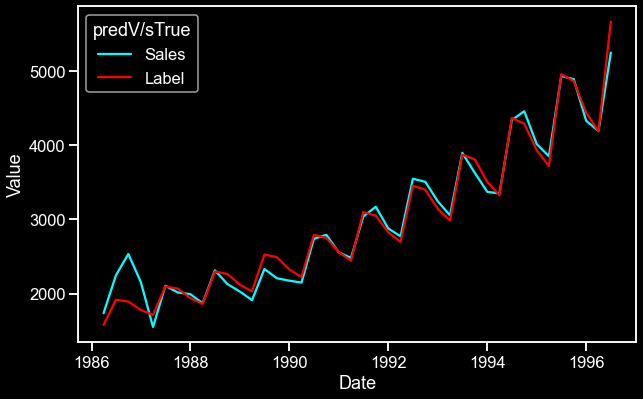

In [50]:
# line plot - View for the entire dataset

viz1 = predictions.loc[:, ["Date", "Sales", "Label"]].melt("Date", var_name = "predV/sTrue", 
                                                           value_name = "Value")
sns.lineplot(data = viz1, x = viz1.Date, y = viz1.Value, hue = "predV/sTrue", 
             palette = ["aqua", "red"]);

Lesser Variance as compared to previous case.

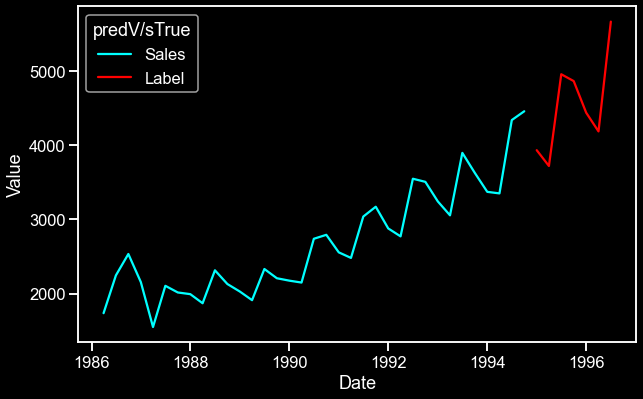

In [51]:
# line plot - View for Train vs test

predictions.Label.iloc[:35] = np.nan
predictions.Sales.iloc[35:] = np.nan

viz4 = predictions.loc[:, ["Date", "Sales", "Label"]].melt("Date", var_name = "predV/sTrue", 
                                                           value_name = "Value")
sns.lineplot(data = viz4, x = viz4.Date, y = viz4.Value, hue = "predV/sTrue", 
             palette = ["aqua", "red"]);

### Data Driven Forecasting Techniques

#### Moving Averages

In [52]:
#Make seperate dataset

data_ma = data_ma.set_index('Date')

#Simple Moving Average SMA
data_ma['3-month-SMA'] = data_ma['Sales'].rolling(window = 3).mean()
data_ma['6-month-SMA'] = data_ma['Sales'].rolling(window = 6).mean()
data_ma['12-month-SMA'] = data_ma['Sales'].rolling(window = 12).mean()

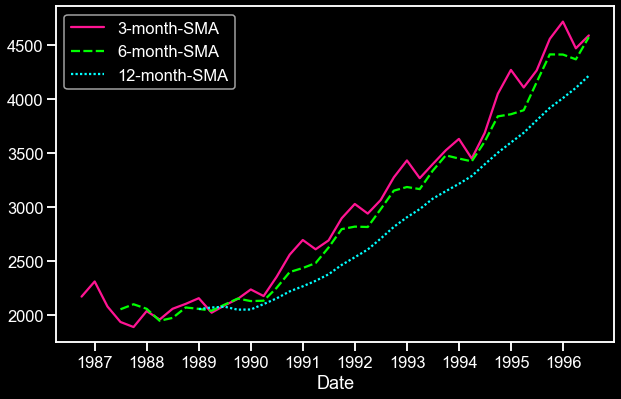

In [53]:
sns.lineplot(data = data_ma[['3-month-SMA', '6-month-SMA', '12-month-SMA']], 
             palette = ["deeppink", "lime", "aqua"]); #SMA Plot

In [54]:
#for 3-Months only since it will have the lowest SMA
data_ma['3-month-SMA'] = data_ma['3-month-SMA'].fillna(0)
rmse_SMA_3Months = mean_squared_error(data_ma.Sales, data_ma['3-month-SMA'], squared = False)
pfm_data_bsd.update({'SMA-3Months':rmse_SMA_3Months}) 
rmse_SMA_3Months

530.974317734843

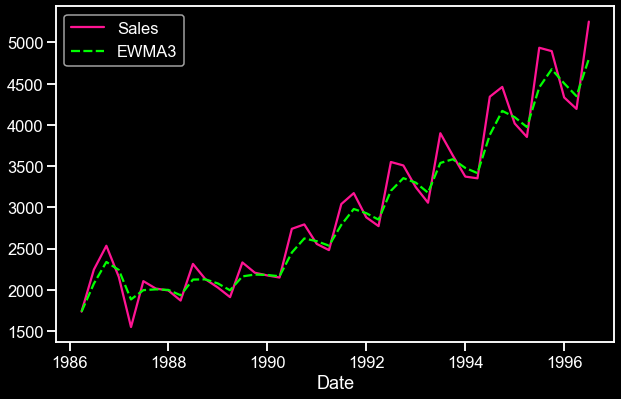

In [55]:
#Exponentially Weighted Moving Average EWMA
data_ma['EWMA3'] = data_ma['Sales'].ewm(span = 3, adjust = True).mean() #3month Span

#Line Plot EWMA
sns.lineplot(data = data_ma[["Sales", "EWMA3"]], palette = ["deeppink", "lime"]); #SMA Plot

In [56]:
#for 3-Months only since it will have the lowest EWMA
data_ma['EWMA3'] = data_ma['EWMA3'] .fillna(0)
rmse_EWMA3 = mean_squared_error(data_ma.Sales, data_ma['EWMA3'] , squared = False)
pfm_data_bsd.update({'EWMA 3Months':rmse_EWMA3}) 
rmse_EWMA3

199.4860437981679

#### Smoothing Techniques

In [57]:
#Simple Exponential Method
ses_model = SimpleExpSmoothing(train["Sales"]).fit(smoothing_level = 0.2)
pred_ses = ses_model.predict(start = test.index[0], end = test.index[-1])
rmse_SES = mean_squared_error(test.Sales, pred_ses, squared = False)
pfm_data_bsd.update({'SES':rmse_SES}) 
rmse_SES

922.9178308307818

In [58]:
# Holt method 
hw_model = Holt(train["Sales"]).fit(smoothing_level = 0.8, smoothing_slope = 0.2)
pred_hw = hw_model.predict(start = test.index[0],end = test.index[-1])
rmse_Holt = mean_squared_error(test.Sales, pred_hw, squared = False)
pfm_data_bsd.update({'Holt':rmse_Holt}) 
rmse_Holt

796.7270706021932

In [59]:
#Holts winter exponential smoothing with additive seasonality and additive trend
hwe_model_add_add = ExponentialSmoothing(train["Sales"], seasonal = "add", trend = "add", 
                                         seasonal_periods = 12).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = test.index[0], end = test.index[-1])
rmse_hwe_add = mean_squared_error(test.Sales, pred_hwe_add_add, squared = False)
pfm_data_bsd.update({'HWE Add. Seas & Add. Trend':rmse_hwe_add}) 
rmse_hwe_add

270.0779086581699

In [60]:
#Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_add = ExponentialSmoothing(train["Sales"], seasonal = "mul", trend = "add", 
                                         seasonal_periods = 12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = test.index[0], end = test.index[-1])
rmse_hwe_mul = mean_squared_error(test.Sales, pred_hwe_mul_add, squared = False)
pfm_data_bsd.update({'HWE Mul. Seas & Add. Trend':rmse_hwe_mul}) 
rmse_hwe_mul                                            

129.2574612883441

Good value.

In [61]:
pfm_data_bsd

{'SMA-3Months': 530.974317734843,
 'EWMA 3Months': 199.4860437981679,
 'SES': 922.9178308307818,
 'Holt': 796.7270706021932,
 'HWE Add. Seas & Add. Trend': 270.0779086581699,
 'HWE Mul. Seas & Add. Trend': 129.2574612883441}

In [62]:
result_data_bsd = pd.DataFrame(pfm_data_bsd.items(), columns = ['MODEL', 'RMSE'])
result_data_bsd.sort_values(by = ['RMSE'])

,MODEL,RMSE
5,HWE Mul. Seas & Add. Trend,129.257461
1,EWMA 3Months,199.486044
4,HWE Add. Seas & Add. Trend,270.077909
0,SMA-3Months,530.974318
3,Holt,796.727071
2,SES,922.917831


HWE Multiplicative Seasonality and Additive Trend has the Lowest RSME value.

###### Model Evaluation - HWE Multiplicative Seasonality and Additive Trend

In [63]:
hwe_mul_model = hwe_model_mul_add.predict(start = data.index[0], end = data.index[-1])
data3['predicted'] = hwe_mul_model
data3.head()

,t,years,quarters,Sales,predicted
0,1,86,Q1,1734.827000,1791.544872
1,2,86,Q2,2244.960999,2122.596467
2,3,86,Q3,2533.804993,2344.352626
3,4,86,Q4,2154.962997,2196.416747
4,5,87,Q1,1547.818996,1822.266507


In [64]:
# add a date column in the dataset
data3['Date'] = pd.date_range(start = '1986-01-01', end = '1996-07-01', freq = 'Q')
data3.head()

,t,years,quarters,Sales,predicted,Date
0,1,86,Q1,1734.827000,1791.544872,1986-03-31
1,2,86,Q2,2244.960999,2122.596467,1986-06-30
2,3,86,Q3,2533.804993,2344.352626,1986-09-30
3,4,86,Q4,2154.962997,2196.416747,1986-12-31
4,5,87,Q1,1547.818996,1822.266507,1987-03-31


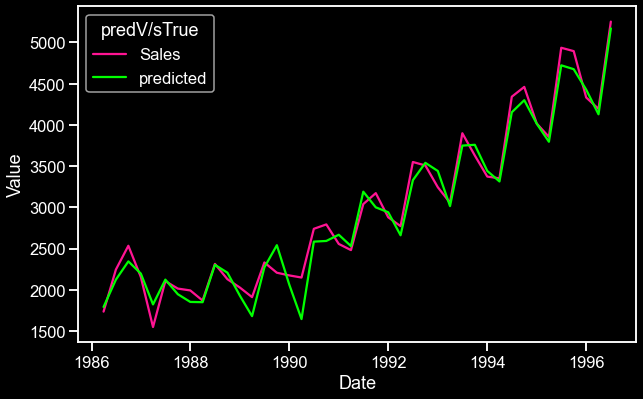

In [65]:
# line plot - View for the entire dataset _ ASQ
viz5 = data3.loc[:, ["Date", "Sales", "predicted"]].melt("Date", var_name = "predV/sTrue", 
                                                         value_name = "Value")
sns.lineplot(data = viz5, x = viz5.Date, y = viz5.Value, hue = "predV/sTrue", 
             palette = ["deeppink", "lime"]);

THe model has the best RMSE value.

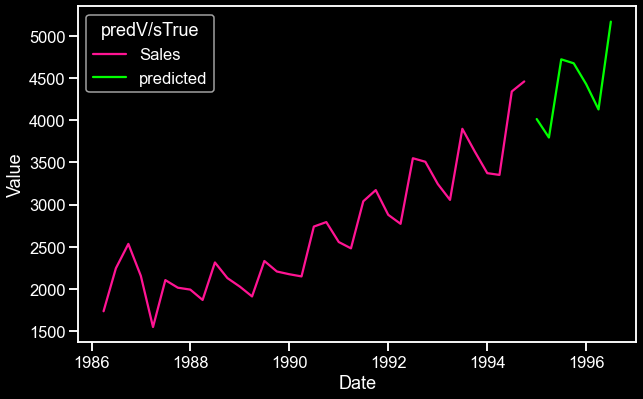

In [66]:
#Line plot - Train V/s Test Plot
data3.predicted.iloc[:35] = np.nan
data3.Sales.iloc[35:] = np.nan

viz6 = data3.loc[:, ["Date", "Sales", "predicted"]].melt("Date", var_name = "predV/sTrue", 
                                                         value_name = "Value")
sns.lineplot(data = viz6, x = viz6.Date, y = viz6.Value, hue = "predV/sTrue",
             palette = ["deeppink", "lime"]);

##### AD-Fuller stationarity test

In [67]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):    
    result = adfuller(series.dropna())  
    labels = ['ADF test statistic', 'p-value', '# lags used', '# observations']
    out = pd.Series(result[0:4], index = labels)
    
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [68]:
data4 = data4.set_index('Date')
data4.head()

,t,years,quarters,Sales,Label
Date,,,,,
1986-03-31,1,86,Q1,1734.827000,1575.795937
1986-06-30,2,86,Q2,2244.960999,1916.533205
1986-09-30,3,86,Q3,2533.804993,1892.576026
1986-12-31,4,86,Q4,2154.962997,1779.082826
1987-03-31,5,87,Q1,1547.818996,1709.488701


In [69]:
#AD- Fuller test
adf_test(data4[['Sales']])

Fail to reject the null hypothesis
Data is non-stationary


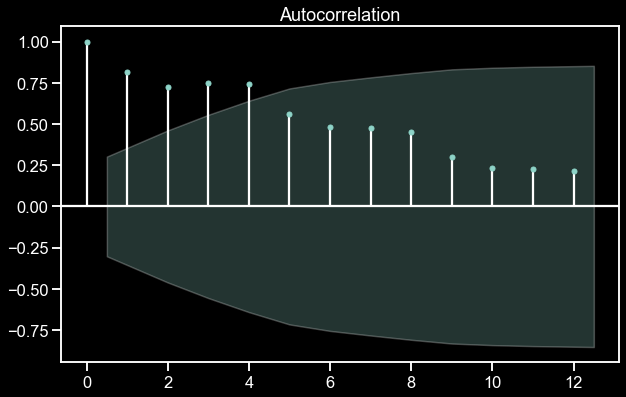

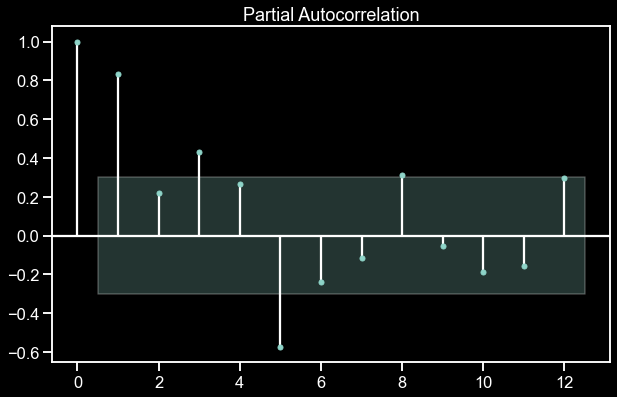

In [70]:
#ACF and PACF Plots
tsa_plots.plot_acf(viz, lags = 12) 
#Autocorrelation Factor >> uptill 6 we have good corr() above +-2 SE.
tsa_plots.plot_pacf(viz, lags = 12) 
#Partial Autocorrelation Factor >> only 9 and 11 show some good corr() +-2 SE.
plt.show()

In [71]:
from pmdarima import auto_arima # for determining ARIMA orders

In [72]:
stepwise_fit = auto_arima(data4.Sales, start_p = 0, start_q = 0,
                          max_p = 12, max_q = 12, m = 12,
                          seasonal = False,
                          d = None, trace = True,
                          error_action = 'ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=617.615, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=619.036, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=607.723, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=617.215, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=608.949, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=606.079, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=607.920, Time=0.24 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=596.966, Time=0.28 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=577.736, Time=0.33 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=579.745, Time=0.31 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=557.235, Time=0.36 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=559.112, Time=0.31 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=562.838, Time=0.43 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   42
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -270.617
Date:                Mon, 12 Jul 2021   AIC                            557.235
Time:                        01:12:51   BIC                            570.943
Sample:                             0   HQIC                           562.227
                                 - 42                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    281.4743     71.164      3.955      0.000     141.995     420.953
ar.L1         -1.0166      0.053    -19.250      0.000      -1.120      -0.913
ar.L2         -1.0084      0.063    -16.106      0.000      -1.131      -0.886
ar.L3         -0.9872      0.023    -43.069      0.000      -1.032      -0.942
ma.L1          0.9264      0.216      4.289      0.000       0.503       1.350
ma.L2          0.5176      0.280      1.850      0.064      -0.031       1.066
ma.L3          0.4710      0.174      2.712      0.007       0.131       0.811
sigma2      2.022e+04   5377.293      3.760      0.000    9678.470    3.08e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 6.05
Prob(Q):                              0.99   Prob(JB):                         0.05
Heteroskedasticity (H):               0.58   Skew:                            -0.76
Prob(H) (two-sided):                  0.31   Kurtosis:                         4.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [73]:
#Fitting a model
from statsmodels.tsa.arima_model import ARIMA

model_arima = ARIMA(train['Sales'], order = (4, 1, 0))
results = model_arima.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                   34
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -226.383
Method:                       css-mle   S.D. of innovations            173.547
Date:                Mon, 12 Jul 2021   AIC                            464.765
Time:                        01:12:52   BIC                            473.923
Sample:                             1   HQIC                           467.888
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            61.5071     33.777      1.821      0.069      -4.695     127.709
ar.L1.D.Sales    -0.1806      0.135     -1.339      0.181      -0.445       0.084
ar.L2.D.Sales    -0.2311      0.141     -1.639      0.101      -0.507       0.045
ar.L3.D.Sales    -0.1456      0.150     -0.971      0.332      -0.440       0.148
ar.L4.D.Sales     0.7209      0.145      4.986      0.000       0.438       1.004
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0558           -0.0000j            1.0558           -0.5000
AR.2           -0.0089           -1.0149j            1.0149           -0.2514
AR.3           -0.0089           +1.0149j            1.0149            0.2514
AR.4            1.2756           -0.0000j            1.2756           -0.0000
-----------------------------------------------------------------------------
"""

In [74]:
pred_arima = results.predict(start = 35, end = len(data4)-1, dynamic = False, typ = 'levels')

### Final Model

In [75]:
#Holts winter exponential smoothing with multiplicative seasonality and additive trend
final_model = ExponentialSmoothing(data_fnl["Sales"], seasonal = "mul",trend = "add",
                                   seasonal_periods = 12).fit() 
pred_final = final_model.predict(start = data.index[0], end = data.index[-1])

#Getting RMSE Score
rmse_final = mean_squared_error(data.Sales, pred_final, squared = False)
rmse_final

154.65045948427777

This score is good.

In [76]:
data_fnl.head()

,t,years,quarters,Sales
0,1,86,Q1,1734.827000
1,2,86,Q2,2244.960999
2,3,86,Q3,2533.804993
3,4,86,Q4,2154.962997
4,5,87,Q1,1547.818996


In [77]:
data_fnl['final_pred'] = pred_final
data_fnl.head()

,t,years,quarters,Sales,final_pred
0,1,86,Q1,1734.827000,1751.064582
1,2,86,Q2,2244.960999,2141.909936
2,3,86,Q3,2533.804993,2333.029922
3,4,86,Q4,2154.962997,2243.157448
4,5,87,Q1,1547.818996,1906.522788


In [78]:
data_fnl['Date'] = pd.date_range(start = '1986-01-01', end = '1996-07-01', freq = 'Q')
data_fnl.head()

,t,years,quarters,Sales,final_pred,Date
0,1,86,Q1,1734.827000,1751.064582,1986-03-31
1,2,86,Q2,2244.960999,2141.909936,1986-06-30
2,3,86,Q3,2533.804993,2333.029922,1986-09-30
3,4,86,Q4,2154.962997,2243.157448,1986-12-31
4,5,87,Q1,1547.818996,1906.522788,1987-03-31


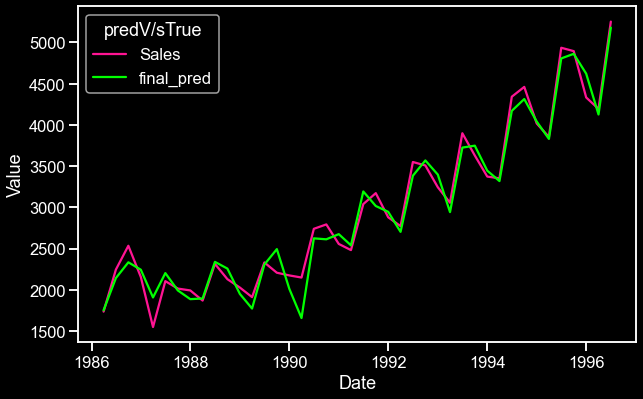

In [79]:
# line plot - View for the entire dataset FInal Model
viz8 = data_fnl.loc[:, ["Date", "Sales", "final_pred"]].melt("Date", var_name = "predV/sTrue", 
                                                             value_name = "Value")
sns.lineplot(data = viz8, x = viz8.Date, y = viz8.Value, hue = "predV/sTrue", 
             palette = ["deeppink", "lime"]);

In [80]:
#Forecasting the future
future = pd.DataFrame(final_model.forecast(8)).reset_index()
future.rename(columns = {'index':'t', 0:'Forecast'}, inplace = True)
future.head()

,t,Forecast
0,42,4929.498608
1,43,4614.623753
2,44,4554.130175
3,45,5773.661620
4,46,5819.106671


In [81]:
#Creating Forecast dataset
forecast_df = pd.concat([data_fnl, future], axis = 0)
forecast_df.drop('Date', axis = 1)
forecast_df['Date'] = pd.date_range(start = '1986-01-01', end = '1998-09-01', freq = 'Q')

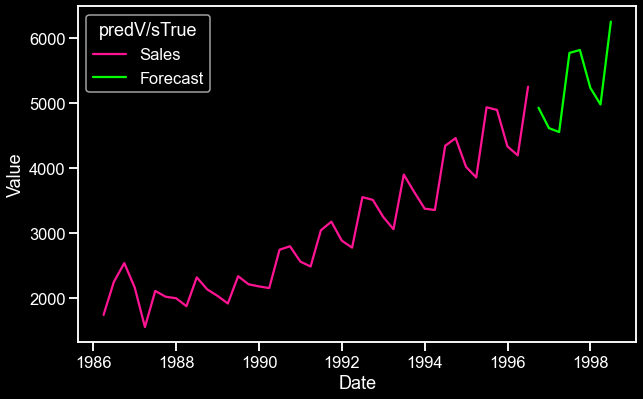

In [82]:
#Future Forecast

viz9 = forecast_df.loc[:, ["Date", "Sales", "Forecast"]].melt("Date", var_name = "predV/sTrue", 
                                                              value_name = "Value")
sns.lineplot(data = viz9, x = viz9.Date, y = viz9.Value, hue = "predV/sTrue", 
             palette = ["deeppink", "lime"]);

Best internal forecast.